In [1]:
from typing import Sequence, Tuple, Union, Optional, Callable, Literal, Protocol
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike


import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
from jax import random as jrandom
import equinox as eqx

import optax

from functools import partial

from typing_extensions import TypeAlias

from dataclasses import dataclass, asdict, astuple

import matplotlib.pyplot as plt
from collections.abc import Callable

from typing import Protocol

import jax.numpy as jnp
from jaxtyping import Array, ArrayLike, Float, ScalarLike

Data: TypeAlias = dict[str, Float[Array, "n_samples ..."]]
#DataGenerator: TypeAlias = Generator[Data, None, None]
from dataclasses import dataclass
from functools import partial
from typing import Final

import jax
import jax.numpy as jnp
import jax.random as jrandom
import jax.scipy.stats as jstats
from jaxtyping import Array, Float, PRNGKeyArray, ScalarLike


print(jax.devices())


[CudaDevice(id=0)]


# Utils

In [2]:
class Range(eqx.Module):
    minval: float = 0.0
    maxval: float = 1.0


class MakeScalar(eqx.Module):
    model: eqx.Module

    def __call__(self, *args, **kwargs):
        out = self.model(*args, **kwargs)
        return jnp.reshape(out, ())
    

def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("$S_0$")
    ax.set_ylabel("$v_0$")
    ax.set_zlabel(label)
    return fig


def mse(y_pred, y_true):
    return jnp.mean((y_pred - y_true)**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))

def normalize(x, x_mean, x_std):
    return (x - x_mean) / x_std


## HVP functions

In [3]:

# HVP for single point and single direction from Bachelier
def hvp(f, x, v):
    return jax.jvp(lambda x_: eqx.filter_grad(f)(x_), (x,), (v,))[1]


# this is a version where we explicitly add a list of boolean values, indicating whether we should compute the hvp for that direction
# TODO isnt this the same as just setting the undesired directions to 0? Then we could just use the normal hvp_batch function
def hvp_cond(f, x, v, eval_hvp):                                   #jnp.zeros(shape=(x.shape[-1],))
    return jax.lax.cond(eval_hvp, lambda _: hvp(f, x, v), lambda _: jnp.zeros_like(v), None)



# from bachelier
def hvp_batch(f, inputs, directions):
    """
    Compute Hessian-vector products: H(x_i) @ v_j
    Args:
        f: scalar-valued function f: R^n -> R
        inputs: [num_inputs, input_dim]
        directions: [num_directions, input_dim]
    Returns:
        hvps: [num_inputs, num_directions, input_dim]
    """
    def hvp_fn(x, v):
        return hvp(f, x, v)
    batched = eqx.filter_vmap(eqx.filter_vmap(hvp_fn, in_axes=(0, None)), in_axes=(None, 0))
    return jnp.transpose(batched(inputs, directions), (1, 0, 2))



def hvp_batch_cond(f, inputs, directions, eval_hvp):
    """
    Compute Hessian-vector products: H(x_i) @ v_j ifff eval_hvp[j] == True
    Args:
        f: scalar-valued function f: R^n -> R
        inputs: [num_inputs, input_dim]
        directions: [num_directions, input_dim]
        eval_hvp: [num_directions] boolean array
            if True, compute H(x_i) @ v_j
            if False, return 0
    Returns:
        hvps: [num_inputs, num_directions, input_dim]
            where hvps[i, j] = np.zeros if eval_hvp[j] == False
    """
    def hvp_cond_fn(x, v, eval_hvp):
        return hvp_cond(f, x, v, eval_hvp)
    batched = eqx.filter_vmap(eqx.filter_vmap(hvp_cond_fn, in_axes=(0, None, None)), in_axes=(None, 0, 0))
    return jnp.transpose(batched(inputs, directions, eval_hvp), (1, 0, 2))




# TODO put cfd stuff this somewhere else, separate file?
def cfd_fn(f, h, x, *args):
    
    def cfd_(direction):
      #jax.debug.print("in cfd_ direction.shape: {shape}", shape=direction.shape)
      
      xph = x + h * direction 
      xmh = x - h * direction 
      fd_of_f = (f(xph, *args) - f(xmh, *args)) / (2 * h)

      #jax.debug.print("in cfd_ fd_of_f.shape: {fd}", fd=fd_of_f.shape)
      return fd_of_f
    
    return cfd_




def cfd_cond_fn(f, batch_size):
    def cfd_cond_(direction, eval_hvp):
        return jax.lax.cond(eval_hvp, lambda direction: f(direction), lambda _: jnp.zeros(shape=(batch_size, direction.shape[-1])), direction)
        
    return eqx.filter_vmap(cfd_cond_, in_axes=(0, 0))




# Reference Models

## Bachelier

In [4]:


class Payoff(Protocol):
    """TODO: ."""

    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_price: Float[ScalarLike, ""]) -> Float[ArrayLike, " n"]:
        """TODO: ."""
        ...

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_price: Float[ScalarLike, ""]) -> Float[ArrayLike, " n"]:
        """TODO: ."""
        ...


class EuropeanPayoff:
    """TODO: ."""

    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        """TODO: ."""
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        """TODO: ."""
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)


In [6]:


def generate_correlation_matrix(key: PRNGKeyArray, n_samples: int) -> Array:
    """TODO: ."""
    data = jrandom.uniform(key, shape=(2 * n_samples, n_samples), minval=-1.0, maxval=1.0)
    covariance = data.T @ data
    inv_vols = jnp.diag(1.0 / jnp.sqrt(jnp.diagonal(covariance)))
    return jnp.linalg.multi_dot([inv_vols, covariance, inv_vols])


class Basket:
    """TODO: ."""


# TODO: seperate the analytic part into a seperate class
# TODO: seperate the basket aspect out of the model
@dataclass
class Bachelier:
    """Bachelier model.

    References:
        https://en.wikipedia.org/wiki/Bachelier_model

        https://iwasawa.us/normal.pdf

    Attributes:
        key: a key for the random number generator of jax.
        n_dims: number of dimensions. A dimension usually corresponds to an asset price.
        weights: an array of weights indicating the importance
            of each dimension of the spots, i.e. the weight of the asset in the basket.
        t_exposure: the start time you get exposed to the option.
        t_maturity: the time the option will expire, i.e. reach its maturity.
        strike_price: the strike price, often refered to as $K$.
        vol_mult: the volatility multiplier. If above 1, more data will be generated on the wings.
        vol_basket: the volatility of the basket. Used to normalize the volatilities.
    """

    key: PRNGKeyArray
    n_dims: Final[int]
    weights: Float[Array, " n_dims"]

    t_exposure: float = 1.0
    t_maturity: float = 2.0
    strike_price: float = 1.10
    vol_mult: float = 1.5
    vol_basket: float = 0.2
    use_antithetic: bool = True

    def __init__(self, key, n_dims, weights):
        """TODO: ."""
        if n_dims != len(weights):
            val = f"Mismatch in number of dimensions ({n_dims}) and number of weights ({weights}) given."
            raise ValueError(val)

        self.key = key
        self.n_dims = n_dims

        # scale weights to sum up to 1
        self.weights = weights / jnp.sum(weights)

    def baskets(self, spots):
        """TODO: ."""
        return jnp.dot(spots, self.weights).reshape((-1, 1))

    @staticmethod
    def path_simulation():
        """TODO: ."""
        pass

    @staticmethod
    def payoff_analytic_differentials(xs, paths, weights, strike_price):
        """TODO: ."""
        spots_end = xs + paths
        baskets_end = jnp.dot(spots_end, weights)
        analytic_differentials = jnp.where(baskets_end > strike_price, 1.0, 0.0)
        analytic_differentials = analytic_differentials.reshape((-1, 1))
        weights = weights.reshape((1, -1))
        # TODO: Replace either with jnp.multiply or jnp.matmul.
        #       Make sure to use the correct one! Here it doesn't
        #       matter since we have (x, 1) but this makes it clearer
        #       what the intention behind this operation is.
        result = analytic_differentials * weights
        return result

    @staticmethod
    def payoff_antithetic_analytic_differentials(xs, paths, weights, strike_price):
        """TODO: ."""
        spots_end_a = xs + paths
        baskets_end_a = jnp.dot(spots_end_a, weights)
        spots_end_b = xs - paths
        baskets_end_b = jnp.dot(spots_end_b, weights)

        differentials_a = jnp.where(baskets_end_a > strike_price, 1.0, 0.0).reshape((-1, 1)) * weights.reshape((1, -1))
        differentials_b = jnp.where(baskets_end_b > strike_price, 1.0, 0.0).reshape((-1, 1)) * weights.reshape((1, -1))
        differentials = 0.5 * (differentials_a + differentials_b)
        return differentials

    @staticmethod
    def payoff(
        xs: Float[Array, "n_samples n_dims"],
        paths: Float[Array, "n_samples n_dims"],
        weights: Float[Array, " n_dims"],
        strike_price: Float[ScalarLike, ""],
    ) -> Float[Array, " n_samples"]:
        """TODO: ."""
        spots_end = xs + paths
        baskets_end = jnp.dot(spots_end, weights)
        pay = EuropeanPayoff.call(baskets_end, strike_price)
        return pay

    @staticmethod
    def antithetic_payoff(
        xs: Float[Array, "n_samples n_dims"],
        paths: Float[Array, "n_samples n_dims"],
        weights: Float[Array, " n_dims"],
        strike_price: Float[ScalarLike, ""],
    ) -> Float[Array, " n_samples"]:
        """TODO: ."""
        spots_end_a = xs + paths
        baskets_end_a = jnp.dot(spots_end_a, weights)
        pay_a = EuropeanPayoff.call(baskets_end_a, strike_price)

        spots_end_b = xs - paths
        baskets_end_b = jnp.dot(spots_end_b, weights)
        pay_b = EuropeanPayoff.call(baskets_end_b, strike_price)

        pay = 0.5 * (pay_a + pay_b)
        return pay
    
    

    def sample(self, key, n_samples: int) -> Data:
        """TODO: ."""


        #  w.l.o.g., initialize spots, i.e. S_0, as all ones
        spots_0 = jnp.repeat(1.0, self.n_dims)

        # generate random correlation matrix
        key, subkey = jrandom.split(key)
        correlated_samples = generate_correlation_matrix(subkey, self.n_dims)

        # TODO: consider using cupy for random number generation in MC simulation
        #       in general we should extract the random number generator to be agnostic

        # generate random volatilities
        key, subkey = jrandom.split(key)
        vols = jrandom.uniform(subkey, shape=(self.n_dims,), minval=5.0, maxval=50.0)

        # W.l.o.g., normalize the volatilities for a given volatility of the basket.
        # It makes plotting the data more convenient.
        normalized_vols = (self.weights * vols).reshape((-1, 1))
        v = jnp.sqrt(jnp.linalg.multi_dot([normalized_vols.T, correlated_samples, normalized_vols]).reshape(1))
        vols = vols * self.vol_basket / v


        t_delta = self.t_maturity - self.t_exposure



        
        diag_v = jnp.diag(vols)
        cov = jnp.linalg.multi_dot([diag_v, correlated_samples, diag_v])
        key, subkey = jrandom.split(key)
        
        ### ---- old with cholesky ---- ####
        # Cholesky
        chol = jnp.linalg.cholesky(cov) * jnp.sqrt(t_delta)
        # increase vols for simulation of xs so we have more samples in the wings
        chol_0 = chol * self.vol_mult * jnp.sqrt(self.t_exposure / t_delta)
        # simulations
        normal_samples = jrandom.normal(subkey, shape=(2, n_samples, self.n_dims))
        paths_0 = normal_samples[0] @ chol_0.T
        paths_1 = normal_samples[1] @ chol.T


        #### ---- new: sample directly from correlated distribution ---- ####
        ## TODO find out why this does not work
        #mean = jnp.zeros(self.n_dims)
        #cov_0 = cov * self.t_exposure * self.vol_mult**2  # Used for paths_0
        #cov_1 = cov * t_delta  # Used for paths_1
        #paths_0 = jrandom.multivariate_normal(subkey, mean, cov_0, shape=(n_samples,))
        #paths_1 = jrandom.multivariate_normal(subkey, mean, cov_1, shape=(n_samples,))



        spots_1 = spots_0 + paths_0




        if self.use_antithetic:
            analytic_differentials_fn = Bachelier.payoff_antithetic_analytic_differentials
            payoff_fn = Bachelier.antithetic_payoff
        else:
            analytic_differentials_fn = Bachelier.payoff_analytic_differentials
            payoff_fn = Bachelier.payoff

        differentials_analytic = analytic_differentials_fn(spots_1, paths_1, self.weights, self.strike_price)
        payoff_fn = partial(payoff_fn, weights=self.weights, strike_price=self.strike_price)

        payoffs_vjp, vjp_fn = jax.vjp(payoff_fn, spots_1, paths_1)
        differentials_vjp = vjp_fn(jnp.ones(payoffs_vjp.shape))[0]

        assert jnp.allclose(differentials_analytic, differentials_vjp)  # noqa: S101


        return {
            "x": spots_1,
            "y": payoffs_vjp,
            "dydx": differentials_vjp,
            "paths1": paths_1, 
        }
    




    def dataloader(self):
        """Yields from already computed data."""
        # TODO: Implement
        pass

    def batch_generator(self, n_batch: int):
        """Generates a batch of data on the fly."""
        while True:
            yield self.sample(n_batch)

#    def generator(self, n_precompute: int) -> DataGenerator:
#        """Generates new data on the fly.
#
#        Note that this generator continues forever. The `n_precompute` parameter is only
#        used to control the number of samples that are computed at once. The generator
#        will then yield `n_precompute` times before computing the next set of data points.
#
#        Args:
#            n_precompute: number of samples to generate at once.
#
#        Yields:
#            A Data object.
#        """
#        while True:
#            samples = self.sample(n_precompute)
#            keys = samples.keys()
#            values = samples.values()
#
#            for i in range(n_precompute):
#                ith_sample = (v[i] for v in values)
#                sample = dict(zip(keys, ith_sample))
#                yield sample


    def get_test_set(self, n_samples):
        return self.analytic(n_samples)



    def analytic(self, n_samples, minval=0.5, maxval=1.5) -> Data:
        """TODO: ."""

        # adjust lower and upper for dimension
        adj = 1 + 0.5 * jnp.sqrt((self.n_dims - 1) * (maxval - minval) / 12)
        adj_lower = 1.0 - (1.0 - minval) * adj
        adj_upper = 1.0 + (maxval - 1.0) * adj

        # draw random spots within range
        self.key, subkey = jrandom.split(self.key)
        spots = jrandom.uniform(subkey, shape=(n_samples, self.n_dims), minval=adj_lower, maxval=adj_upper)
        
        baskets = jnp.dot(spots, self.weights).reshape((-1, 1))
        time_to_maturity = self.t_maturity - self.t_exposure
        
        prices = Bachelier.Call.price(baskets, self.strike_price, self.vol_basket, time_to_maturity)
        prices = prices.reshape((-1,))
        # prices = prices.reshape((-1, 1))

        # in analytical solution we directly compute greeks w.r.t. the basket price
        greeks = Bachelier.Call.greeks(baskets, self.strike_price, self.vol_basket, time_to_maturity)

        # TODO: generalize
        deltas = greeks[0] @ self.weights.reshape((1, -1))
        gammas = greeks[1]
        vegas = greeks[2]

        return {
            "x": spots,
            "y": prices,
            "dydx": deltas,
            "ddyddx": gammas,
            "dydvol": vegas,
            "baskets": baskets

        }




    class Call:
        """Analytic solutions to price and greeks (delta, gamma, vega) of call option on Bachelier."""

        @staticmethod
        def price(spot, strike, vol, t):
            r"""Analytical solution to the undiscounted call option price.

            As in equation (3) of https://arxiv.org/pdf/2104.08686.pdf.

            Args:
                spot: the spot price, also denoted as $S_0$.
                strike: an array of strike prices, also denoted as $K$.
                vol: volatility, also denoted as $\sigma_N$.
                t: time to maturity, also denoted as $T - t$ or $T$.


            Returns:
                TODO
            """
            sqrt_t = jnp.sqrt(t)
            d = (spot - strike) / (vol * sqrt_t)
            normal_cdf_d = jstats.norm.cdf(d)
            normal_pdf_d = jstats.norm.pdf(d)
            price = vol * sqrt_t * (d * normal_cdf_d + normal_pdf_d)
            return price

        @staticmethod
        def delta(spot, strike, vol, t) -> Array:
            r"""Analytical delta.

            The delta is the derivative of the price sensitivity w.r.t. the spot price.

            As in 5.1 of https://arxiv.org/pdf/2104.08686.pdf.

            Args:
                spot: the spot price, also denoted as $S_0$.
                strike: an array of strike prices, also denoted as $K$.
                vol: volatility, also denoted as $\sigma_N$.
                t: time to maturity, also denoted as $T - t$ or $T$.


            Returns:
                TODO
            """
            d = (spot - strike) / (vol * jnp.sqrt(t))
            return jstats.norm.cdf(d)

        @staticmethod
        def gamma(spot, strike, vol, t) -> Array:
            r"""Analytical gamma.

            The gamma is the 2nd-order derivative of the price
            sensitivity w.r.t. the spot price.

            As in 5.1 of https://arxiv.org/pdf/2104.08686.pdf.

            Args:
                spot: the spot price, also denoted as $S_0$.
                strike: an array of strike prices, also denoted as $K$.
                vol: volatility, also denoted as $\sigma_N$.
                t: time to maturity, also denoted as $T - t$ or $T$.


            Returns:
                TODO
            """
            d = (spot - strike) / (vol * jnp.sqrt(t))
            return jstats.norm.pdf(d) / (vol * jnp.sqrt(t))

        @staticmethod
        def vega(spot, strike, vol, t) -> Array:
            r"""Analytical vega.

            The vega is the 2nd-order derivative of the price
            sensitivity w.r.t. the volatility.

            As in 5.1 of https://arxiv.org/pdf/2104.08686.pdf.

            Args:
                spot: an array of spot prices, also denoted as $S_0$.
                strike: an array of strike prices, also denoted as $K$.
                vol: volatility, also denoted as $\sigma_N$.
                t: time to maturity, also denoted as $T - t$ or $T$.


            Returns:
                TODO
            """
            d = (spot - strike) / (vol * jnp.sqrt(t))
            return jnp.sqrt(t) * jstats.norm.pdf(d)

        @staticmethod
        def greeks(spot, strike, vol, t) -> tuple[Array, Array, Array]:
            r"""Greeks.

            As in 5.1 of https://arxiv.org/pdf/2104.08686.pdf.

            Args:
                spot: an array of spot prices, also denoted as $S_0$.
                strike: an array of strike prices, also denoted as $K$.
                vol: volatility, also denoted as $\sigma_N$.
                t: time to maturity, also denoted as $T - t$ or $T$.


            Returns:
                TODO
            """
            call = Bachelier.Call
            deltas = call.delta(spot, strike, vol, t)
            gammas = call.gamma(spot, strike, vol, t)
            vegas = call.vega(spot, strike, vol, t)
            return deltas, gammas, vegas
        

    
    def visualize_dataset(self, dataset, is_test):

        if is_test:
            name = "Test"
            baskets = dataset["baskets"]
        else:
            name = "Train"
            baskets = jnp.dot(dataset["x"], self.weights).reshape((-1, 1))

        
        y = dataset["y"]
        dydx = dataset["dydx"]
        if is_test:
            ddyddx = dataset["ddyddx"]

        
        # Create a single figure with 3 subplots
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot the first subplot
        axes[0].plot(baskets, y, '.', markersize=1)
        axes[0].set_title(f"Values {name}")

        # Plot the second subplot
        dydx_idx = 0
        axes[1].plot(baskets, dydx[:, dydx_idx], '.', markersize=1)
        axes[1].set_title(f"Differentials {name}")

        if is_test:
            # Calculate and plot gammas in the third subplot
            #pred_gammas = jnp.sum(pred_ddyddx, axis=(1, 2))
            axes[2].plot(baskets, ddyddx, '.', markersize=1)
            axes[2].set_title(f"Gammas {name}")

        # Adjust the layout and save the figure to a PDF file
        plt.tight_layout()
        plt.show()
        


## Heston

In [ ]:
from typing import Final
from dataclasses import field
    
class Heston(eqx.Module):

    key: PRNGKeyArray
    
    # for basket
    basket_dim: Final[int]
    basket_weights: Float[Array, "basket dim"]


    spot_range:Range = Range(50.0, 150.0)
    vol_range: Range = Range(0.01, 0.1)

    mc_time_steps: int = 1024 # number of time steps for the Monte Carlo simulation
     
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    T: float = 5.0          # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility


    # for semi-closed-form solution
    num_w: int = 512
    w_max: float = 100.0

    was_normalized = True
    y_std: float = 31.37 # TODO why? or set dynamically
    # derived, init‑only fields
    x_mean: Float[Array, "basket_dim 2"] = field(init=False)
    x_std:  Float[Array, "basket_dim 2"] = field(init=False)
    n_dims: int = field(init=False)


    def __post_init__(self):

        # Uniform[a,b] has mean (a+b)/2, var (b−a)**2/12
        mean_spot = 0.5 * (self.spot_range.minval + self.spot_range.maxval)
        std_spot = jnp.sqrt((self.spot_range.maxval - self.spot_range.minval) ** 2 / 12)
        mean_vol  = 0.5 * (self.vol_range.minval  + self.vol_range.maxval)
        std_vol  = jnp.sqrt((self.vol_range.maxval  - self.vol_range.minval ) ** 2 / 12)

        means = jnp.stack([
            jnp.full(self.basket_dim, mean_spot),
            jnp.full(self.basket_dim, mean_vol),
        ], axis=1)  # shape = (basket_dim, 2)

        stds = jnp.stack([
            jnp.full(self.basket_dim, std_spot),
            jnp.full(self.basket_dim, std_vol),
        ], axis=1)

        # Bypass frozen guard
        object.__setattr__(self, "x_mean", means)
        object.__setattr__(self, "x_std",  stds)
        
        
        n_dims = 2*self.basket_dim
        object.__setattr__(self, "n_dims", n_dims)

 
    
    


    def closed_form_price(self, S0, v0):
        """
        Compute the Heston model European call price using the semi-closed-form solution using numerical integration in JAX.

        Math from:  https://www.ma.imperial.ac.uk/~ajacquie/IC_Num_Methods/IC_Num_Methods_Docs/Literature/Heston.pdf
        and form:   https://xilinx.github.io/Vitis_Libraries/quantitative_finance/2019.2/methods/cf-ht.html#chrso2014
        
        Parameters:
        - S0: initial spot price
        - v0: initial variance
       
        Returns:
        - call option price under Heston model
        """

        sigma = self.xi # volatility of volatility

        # integration grid
        w = jnp.linspace(0.0, self.w_max, self.num_w)[1:]  # avoid w=0

        # Heston characteristic function components
        a = self.kappa * self.theta
        def C_D(wi):
            alpha = -0.5 * wi**2 - 0.5j * wi
            beta  = alpha - 1j * self.rho * sigma * wi
            gamma = 0.5 * sigma**2

            h = jnp.sqrt(beta**2 - 4 * alpha * gamma)
            rp = (beta + h) / (sigma**2)
            rm = (beta - h) / (sigma**2)
            g = rm / rp

            exp_neg_ht = jnp.exp(-h * self.T)
            C = a * (rm * self.T - (2.0 / sigma**2) * jnp.log((1 - g * exp_neg_ht) / (1 - g)))
            D = rm * (1 - exp_neg_ht) / (1 - g * exp_neg_ht)
            return C, D

        # vectorize C and D over w
        C_vec, D_vec = jax.vmap(C_D)(w)

        # characteristic function Psi
        log_term = jnp.log(S0) + self.r * self.T
        def Psi(wi, Ci, Di):
            return jnp.exp(Ci * self.theta + Di * v0 + 1j * wi * log_term)

        Psi_w      = Psi(w,      C_vec, D_vec)
        Psi_w_minus_i = Psi(w - 1j, *jax.vmap(C_D)(w - 1j))
        Psi_minus_i = Psi(-1j, *C_D(-1j))

        # integrands for Pi1 and Pi2
        integrand1 = jnp.real(jnp.exp(-1j * w * jnp.log(self.K)) * Psi_w_minus_i / (1j * w * Psi_minus_i))
        integrand2 = jnp.real(jnp.exp(-1j * w * jnp.log(self.K)) * Psi_w      / (1j * w))

        # numerical integration via the trapezoidal rule
        Pi1 = 0.5 + (1.0 / jnp.pi) * jnp.trapezoid(integrand1, w)
        Pi2 = 0.5 + (1.0 / jnp.pi) * jnp.trapezoid(integrand2, w)

        # final price
        price = S0 * Pi1 - jnp.exp(-self.r * self.T) * self.K * Pi2
        return price
    

    def closed_form_basket_price(self, basket_S0s, basket_v0s):
        # vectorize single‐asset pricer over the basket axis
        prices = jax.vmap(self.closed_form_price)(basket_S0s, basket_v0s)
        return jnp.dot(self.basket_weights, prices)
    

    def closed_form_basket_price_x(self, x_flat):
        d = self.basket_dim
        S0s = x_flat[:d]        # first n_dims entries
        v0s = x_flat[d:]        # next n_dims entries
        return self.closed_form_basket_price(S0s, v0s)


    def get_test_set(self, n_samples):
        return self.sample(self.key, n_samples, is_test=True)


    def sample(self, key, n_samples=256, is_test=False):    
        
        key, subkey = jrandom.split(self.key)
        
        minvals=jnp.array([self.spot_range.minval, self.vol_range.minval])
        maxvals=jnp.array([self.spot_range.maxval, self.vol_range.maxval])
        
        initial_states = jrandom.uniform(
            subkey, 
            shape=(n_samples, self.basket_dim, 2), 
            minval=minvals, 
            maxval=maxvals
        ) # (batch, n_dims, 2)
        S0s = initial_states[..., 0]    # (batch, n_dims)
        v0s = initial_states[..., 1]     # (batch, n_dims)
    



        value_and_grad_fn = jax.value_and_grad(self.closed_form_basket_price, argnums=(0,1))
        y, (dS0s, dV0s) = jax.vmap(value_and_grad_fn)(S0s, v0s)
        dydx = jnp.stack([dS0s, dV0s], axis=-1)
        # x:     (batch, n_dims, 2)
        # y:     (batch,)
        # dydx:  (batch, n_dims, 2)
        #print("x shape: ", initial_states.shape)
        #print("y shape: ", y.shape)
        #print("dydx shape: ", dydx.shape)

        
        


        ## Normalize the data
        # TODO make this work
        x_mean = jnp.mean(initial_states, axis=0)   # (basket, 2)
        x_std = jnp.std(initial_states, axis=0)     # (basket, 2)
        y_mean = jnp.mean(y)                        # scalar
        y_std = jnp.std(y)                          # scalar        
        x_normalized = normalize(initial_states, x_mean, x_std)
        y_normalized = normalize(y, y_mean, y_std)
        dydx_normalized = dydx * (x_std / y_std)[None, ...]

        norm_values = {
            "x_mean": x_mean,
            "x_std": x_std,
            "y_mean": y_mean,
            "y_std": y_std,
        }

    
        ## flatten before returning    
        x_flat = initial_states.reshape(initial_states.shape[0], -1)
        dydx_flat = dydx.reshape(dydx.shape[0], -1)
        x_normalized_flat = x_normalized.reshape(x_normalized.shape[0], -1)
        x_raw_flat = initial_states.reshape(initial_states.shape[0], -1)
        dydx_normalized_flat = dydx_normalized.reshape(dydx_normalized.shape[0], -1)

        if not is_test:
            # TODO move normalization out of sample function and call in loss function
            #return x_flat, y, dydx_flat, None
            return x_normalized_flat, y_normalized, dydx_normalized_flat, norm_values



        if is_test:
            # use jax.hessian to compute the second derivatives
            
            x_flat = initial_states.reshape(n_samples, 2*self.basket_dim)

            H_full = jax.vmap(jax.hessian(self.closed_form_basket_price_x))(x_flat)

            H_blocks = H_full.reshape(
                n_samples,
                self.basket_dim, 2,
                self.basket_dim, 2
            ) # (batch, basket, 2 basket, 2)

            # TODO when calculating 2nd order loss with basket size >1 we
            # do actually need the full Hessian returned. Then diag only for visualization?
            #print("H_blocks shape", H_blocks.shape)


            ## only care about diagonal asset‐blocks (i=j)
            #H_diag = jnp.stack([H_blocks[:, i, :, i, :] for i in range(self.basket_dim)], axis=1)  # -> (batch, basket_dim, 2, 2)
            #ddyddx = H_diag
            ##print("ddyddx shape: ", ddyddx.shape)
            ## normalizing the data
            #scale = (x_std[:, :, None] * x_std[:, None, :]) / y_std  
            ## (basket_dim, 2, 2)
            ## add a batch‐axis
            #scale = scale[None, ...]  
            ##(1, basket_dim, 2, 2)
            #ddyddx_normalized =  ddyddx * scale
            
            scale_full = (x_std[:, :, None, None] * x_std[None, None, :, :]) / y_std
            # scale_full: (n, 2, n, 2)

            # 4) broadcast and apply
            H_blocks_norm = H_blocks * scale_full[None, ...]
            # H_blocks_norm: (batch, n, 2, n, 2)
            #norm_values["H_scale_full"] = scale_full
            ddyddx_normalized = H_blocks_norm


            # TODO move normalization out of sample function and call in loss function
            
            #return x_flat, y, dydx_flat, H_blocks, None
            return x_normalized_flat, y_normalized, dydx_normalized_flat, ddyddx_normalized, norm_values






    def visualize_dataset(self, dataset, name, second_order):
        # visulaize the test set

        if second_order:
            x, y, dydx, ddyddx, _ = dataset
        else:
            x, y, dydx, _ = dataset
        
        x = x.reshape(x.shape[0], self.basket_dim, 2)
        dydx = dydx.reshape(dydx.shape[0], self.basket_dim, 2)


        
        # selecting first basket dimension
        basket_i = 0

        x = x[:, basket_i, :]  # (batch_size, 2)
        y = y  # (batch_size, )
        dydx = dydx[:, basket_i, :]  # (batch_size, 2)
        
        if second_order:
            ddyddx = jnp.stack([ddyddx[:,i,: ,i,:] for i in range(self.basket_dim)], axis=1)
            ddyddx = ddyddx[:, basket_i, :, :]  # (batch_size, k_probe_directions, 2, 2)

        ## average over the basket dimension
        #x = x.mean(axis=1)
        #y = y
        #dydx = dydx.mean(axis=1) 
        #ddyddx = ddyddx.mean(axis=2)

        print("shapes without basket dimension:")
        print("x shape: ", x.shape)
        print("y shape: ", y.shape)
        print("dydx shape: ", dydx.shape)
        if second_order:
            print("ddyddx shape: ", ddyddx.shape)




        xs = x[..., 0]
        ys = x[..., 1]


        fig_payoff = plot_3d_differential_data(xs, ys, y, f"payoff\n{name} target")

        fig_dS = plot_3d_differential_data(xs, ys, dydx[:, 0], f"1st-order diff payoff - dS\n{name} target")
        fig_dv = plot_3d_differential_data(xs, ys, dydx[:, 1], f"1st-order diff payoff - dv\n{name} target")
        


        if second_order:
            fig_dS = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 0], f"2nd-order diff payoff - dSdS\n{name} target")
            fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 1], f"2nd-order diff payoff - dSdv\n{name} target")
            fig_dS = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 0], f"2nd-order diff payoff - dvdS\n{name} target")
            fig_dv = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 1], f"2nd-order diff payoff - dvdv\n{name} target")




# Get and Visualize Data

In [78]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, subkey = jrandom.split(key)

In [79]:

basket_dim = 1
ref_model_heston = Heston(
    key = key,
    basket_dim=basket_dim,
    basket_weights=jrandom.uniform(subkey, shape=(basket_dim,), minval=1.0, maxval=10.0),
    spot_range = Range(50.0, 150.0),
    vol_range = Range(0.01, 0.1),
    mc_time_steps=1024,
    K= 100.0,
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0
)

basket_dim = 7
ref_model_bachelier = Bachelier(
    key,
    n_dims=basket_dim, 
    weights=jrandom.uniform(subkey, shape=(basket_dim,), minval=1.0, maxval=10.0)
)

#ref_model = ref_model_bachelier
ref_model = ref_model_heston



In [80]:
test_set = ref_model.get_test_set(n_samples=1024)
y_std = test_set[4]["y_std"]
print(y_std)
train_sample_batch = ref_model.sample(key=key, n_samples=256)

31.550653


shapes without basket dimension:
x shape:  (1024, 2)
y shape:  (1024,)
dydx shape:  (1024, 2)
ddyddx shape:  (1024, 2, 2)
shapes without basket dimension:
x shape:  (256, 2)
y shape:  (256,)
dydx shape:  (256, 2)


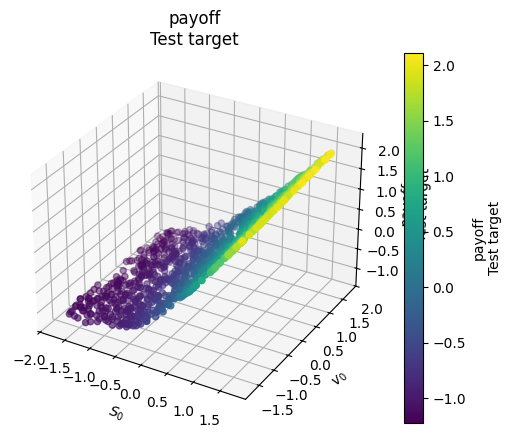

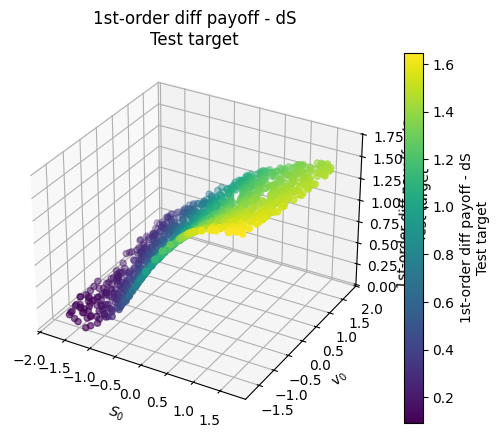

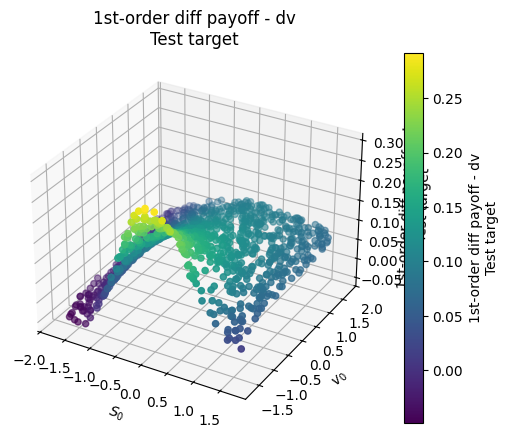

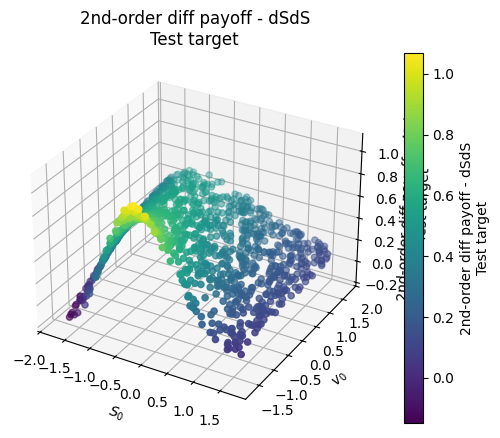

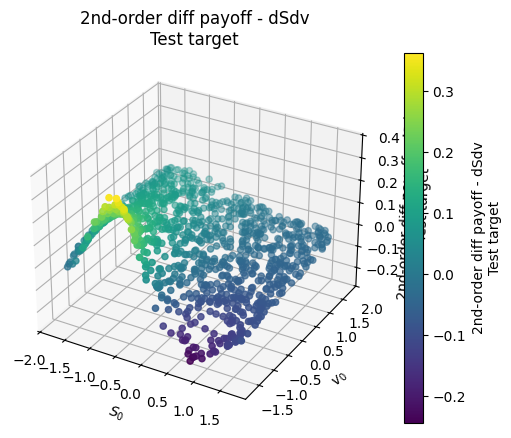

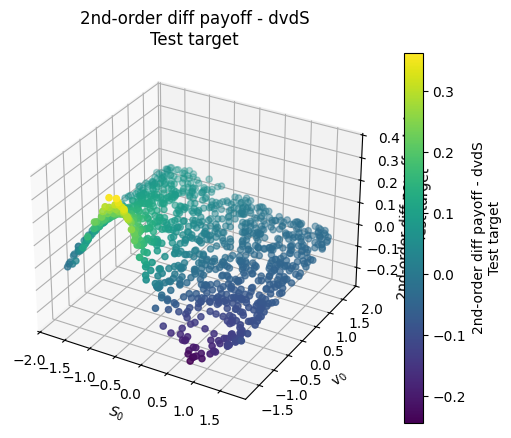

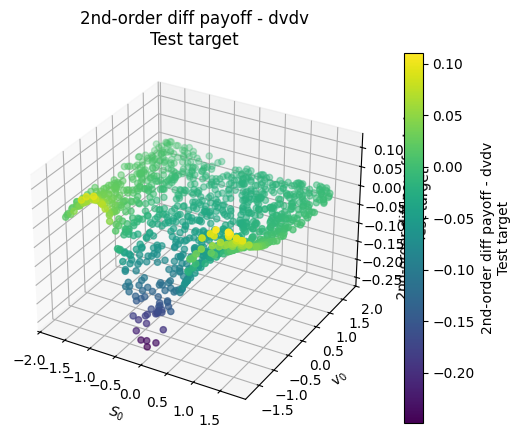

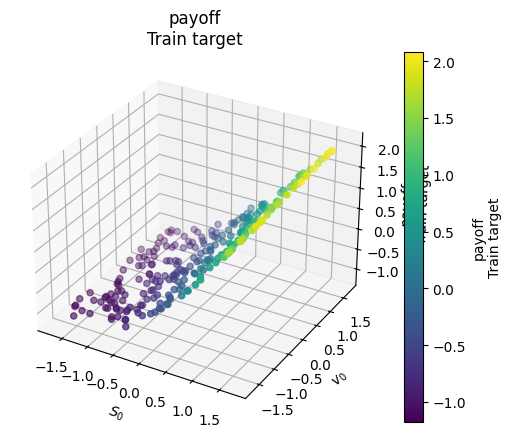

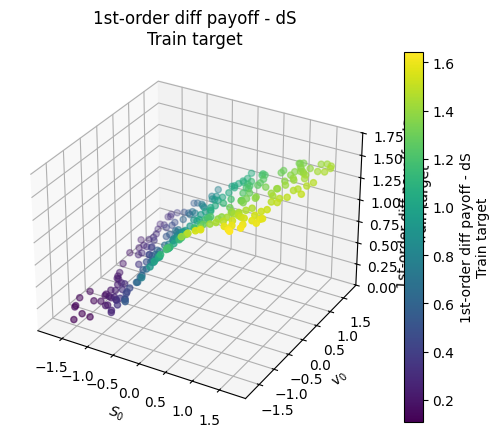

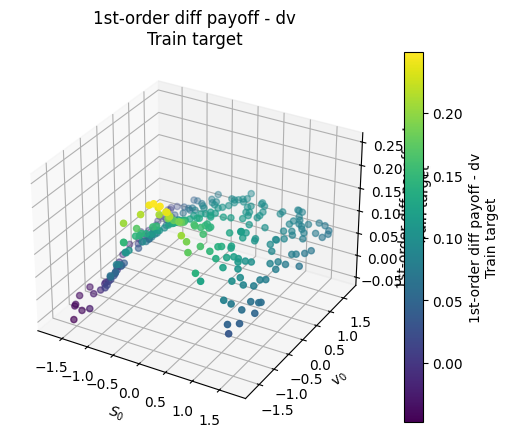

In [81]:
ref_model.visualize_dataset(test_set, name="Test", second_order=True)
ref_model.visualize_dataset(train_sample_batch, name="Train", second_order=False)

# Get Directions

In [82]:
def normalize_vectors(vectors):
    return vectors / jnp.linalg.norm(vectors, axis=1, keepdims=True)

def generate_random_vectors(k, dim, key, normalize=True):
    key, subkey = jax.random.split(key)
    vectors = jax.random.normal(subkey, shape=(k, dim))
    if normalize:
        vectors = normalize_vectors(vectors)
    return vectors

def get_random_directions():
    # TODO
    return



In [83]:
# TODO clean up

def get_rand_SVD_directions(f, x, x_std, k, key, kappa=0.95, is_payoff_fn=True, normalize=True):

    #dim = x.shape[-1]
    #sketch_directions = generate_random_vectors(k, dim, key) # (k, dim)
    
    sketch_directions = jrandom.normal(key, shape=(k, ref_model.n_dims))
    
    #jax.debug.print("sd.shape {shape}", shape=sketch_directions.shape)

    # if f = price function, not model
    if is_payoff_fn:
        sketch_directions = sketch_directions.reshape(k, ref_model.basket_dim, 2)
        dirs_scaled = sketch_directions * x_std[None, :, :] # (k, basket, 2)
        #jax.debug.print("scaled.shape {shape}", shape=dirs_scaled.shape)    
        dirs_scaled_flat  = dirs_scaled.reshape(k, ref_model.n_dims) # (k, 2*basket)
        #jax.debug.print("flat.shape {shape}", shape=dirs_scaled_flat.shape)
        sketch_directions = dirs_scaled_flat
    


    ## Step 1: build sketch Y = H @ sketch_directions
    #Y = hvp_batch(f=f, inputs=x, directions=sketch_directions) # (batch_size, k, dim)
    ##jax.debug.print("Y.shape {shape}", shape=Y.shape)
    ## TODO understand if averaging over batch_size is the correct approach
    #Y = jnp.mean(Y, axis=0)  # (k, dim)
    #Y = Y.T # (dim, k)
    ##jax.debug.print("Y.shape {shape}", shape=Y.shape)


    Y = hvp_batch(
        f=f,
        inputs=x, 
        directions=sketch_directions
    ) # (batch, k, 2*basket)
    #jax.debug.print("Y.shape {shape}", shape=Y.shape)
    # TODO re-normalize here ????

    Y = jnp.mean(Y, axis=0)  # (k, dim)
    Y = Y.T # (2*basket, k)
    #jax.debug.print("Y.shape {shape}", shape=Y.shape)
    #return sketch_directions.reshape(k, basket_dim, 2), None, None


    ## power iterated version of step 1
    #Y = hvp_power_iterated_sketch(f=f, x=x, sketch_directions=sketch_directions, q=3) # (k, dim)
    #Y = Y.T # (dim, k)
    
    
    
    # Step 2: orthonormalize Y
    # TODO breaks when k > dim, which I guess makes sense
    Q, _ = jnp.linalg.qr(Y) # (*2basket, k)  
    #jax.debug.print("Q.shape {shape}", shape=Q.shape)
    #return sketch_directions.reshape(k, basket_dim, 2), None, None





    ## Step 3: each row of B is H @ q_i
    #B_rows = hvp_batch(f=f, inputs=x, directions=Q.T) # (batch_size, k, dim)
    ##jax.debug.print("B_rows.shape {shape}", shape=B_rows.shape)  
    ## TODO understand if averaging over batch_size is the correct approach
    #B_rows = jnp.mean(B_rows, axis=0) # (k, dim)
    ##jax.debug.print("B_rows.shape {shape}", shape=B_rows.shape)
    #B = jnp.stack(B_rows, axis=0) # (k, dim)
    ##jax.debug.print("B.shape {shape}", shape=B.shape)


    B_rows = hvp_batch(
        f=f,
        inputs=x, 
        directions=Q.T
    ) # (batch, k, in_dim)
    #jax.debug.print("B_rows.shape {shape}", shape=B_rows.shape)

    B_rows = jnp.mean(B_rows, axis=0)  # (k, in_dimm)
    B = jnp.stack(B_rows, axis=0) # (k, in_dimm)
    #jax.debug.print("B.shape {shape}", shape=B.shape)
    



    # Step 4: SVD on B
    U_tilde, S, Vt = jnp.linalg.svd(B, full_matrices=False) # (k, k)
    #jax.debug.print("U_tilde.shape {shape}", shape=U_tilde.shape)
   


    # Step 5: Lift back U = Q @ U_tilde
    U = Q @ U_tilde  # (2*basket, k)
    U = U.T # (k, 2*basket)
    #jax.debug.print("U.shape {shape}", shape=U.shape)

    # TODO re-normalize here ????

    
    S_var = S**2 / jnp.sum(S**2)
    eval_dir = (~(jnp.cumsum(S_var) > kappa)).at[0].set(True) # make use that at least the first principal component is always actively used
    k_dir = jnp.sum(eval_dir) # number of principal components used
    

    return U.reshape(k, ref_model.basket_dim, 2), eval_dir, k_dir


# Train Setup

## NN Model

In [84]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
  out, in_ = weight.shape
  stddev = jnp.sqrt(1 / in_)
  return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  weights = get_weights(model)
  new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
  new_model = eqx.tree_at(get_weights, model, new_weights)
  return new_model

In [85]:
# undo normalization of x for pricing function
def un_normalize_x(x, x_mean, x_std):
   
   x_norm = x.reshape(x.shape[0], ref_model.basket_dim, 2)                      # (batch, n, 2)                                 # (n, 2)
   x_raw  = x_norm * x_std[None, :, :] + x_mean[None, :, :]      # (batch, n, 2)
   x_raw_flat = x_raw.reshape(x.shape[0], ref_model.n_dims)               # (batch, 2*n)

   #x_raw_flat = x * x_std.ravel()[None, :] + x_mean.ravel()[None, :]

   return x_raw_flat
    

## Loss Functions

In [ ]:
def standard_loss_fn(model, batch):
    x = batch[0]
    y = batch[1]
    y_pred = vmap(model)(x)
    return mse(y, y_pred)



@eqx.filter_jit
def second_order_loss_fn(model: eqx.nn.MLP, batch, key, ref_model) -> Float:
    
      
    x = batch[0]
    y = batch[1]
    dydx = batch[2]
    
    
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(MakeScalar(model)))(x)
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)

    value_loss = mse(y_pred, y)
    grad_loss = mse(dydx_pred, dydx)
    
    #print("y_pred shape: ", y_pred.shape)
    #print("dydx_pred shape: ", dydx_pred.shape)
    #print("")
    #return .0
    
    

 
    x_raw = x
    if ref_model.was_normalized:
        x_raw = un_normalize_x(x, x_mean=ref_model.x_mean, x_std=ref_model.x_std)



    k = 2

    # 2nd order loss in random directions
    key, subkey = jrandom.split(key)
    rand_directions = jrandom.normal(subkey, shape=(k, ref_model.basket_dim, 2))
    # (k, basket, 2)

    rand_svd_directions_payoff, eval_dir, k_dir = get_rand_SVD_directions(
                                    f=ref_model.closed_form_basket_price_x,
                                    x=x_raw,
                                    x_std=ref_model.x_std,
                                    k=k,
                                    key=key,
                                    is_payoff_fn=True
                                    )
    rand_svd_directions_model, eval_dir, k_dir = get_rand_SVD_directions(
                                    f=MakeScalar(model),  
                                    x=x,
                                    x_std=ref_model.x_std,
                                    k=k,
                                    key=key,
                                    is_payoff_fn=False
                                    )
    stacked = jnp.stack([rand_svd_directions_payoff, rand_svd_directions_model], axis=2)         # (k, batch_dim, 2, 2)
    interleaved_rand_svd_dirs = stacked.reshape((2*k, ref_model.basket_dim, 2))
   

    #eval_dir = jnp.array([True, True, True, True])
    ## (k, basket, 2)
    #if epoch_percent < 0.3:
    #    value_loss = mse(y_pred, y)
    #    grad_loss = mse(dydx_pred, dydx)
    #    loss = 0.5*value_loss + 0.5*grad_loss
    #    return loss
    #if epoch_percent >= 0.3:
    #    eval_dir = jnp.array([True, False, False, False])
    #if epoch_percent >= 0.8:
    #    eval_dir = jnp.array([True, True, False, False])
    
    
    
    #directions = rand_directions
    #directions = rand_svd_directions
    directions = interleaved_rand_svd_dirs
    k = directions.shape[0]



   #### ---- Second-Order Targets via HVPs ---- ####
    

    
    dirs_scaled = directions * ref_model.x_std
    dirs_scaled_flat  = dirs_scaled.reshape(k, ref_model.n_dims) 
    
    # all directions
    target_hvps = hvp_batch(
        f=ref_model.closed_form_basket_price_x,
        inputs=x_raw, 
        directions=dirs_scaled_flat
    )
    
    ## conditional directions
    #target_hvps = hvp_batch_cond(f=ref_model.closed_form_basket_price_x, 
    #                                inputs=x_raw_flat, 
    #                                directions=dirs_scaled_flat,
    #                                eval_hvp=eval_dir,
    #                                )
    
    ## CFD
    #D_payoff_fn = jax.vmap(jax.grad(ref_model.closed_form_basket_price_x))
    ## central finite differences derivative
    #h = 1e-1
    #cfd_of_dpayoff_fn = cfd_fn(D_payoff_fn, h, x_raw_flat) 
    ## conditional directions
    #cfd_of_dpayoff_cond_fn = cfd_cond_fn(cfd_of_dpayoff_fn, batch_size=x.shape[0]) # TODO get rid of the explicit batch size dependency
    #ddpayoff_cond = cfd_of_dpayoff_cond_fn(dirs_scaled_flat, eval_dir)
    #target_hvps = jnp.transpose(ddpayoff_cond, (1, 0, 2))
    ##jax.debug.print("ddpayoff_cond[{i}] {v}", i=i, v=ddpayoff_cond[i]) 


    # TODO put in separate function
    # re-normalize target_hvps for comparison with model preds
    # TODO thius is ugly af
    hvp = target_hvps.reshape(x.shape[0], k, ref_model.basket_dim, 2)          # (batch, k, n, 2)
    diag_scale = ref_model.x_std / ref_model.y_std                              # (n, 2)
    hvp_norm = hvp * diag_scale[None, None, :, :]                # (batch, k, n, 2)
    target_hvps = hvp_norm.reshape(x.shape[0], k, ref_model.n_dims)





    

    #### ---- Second-Order Predicitons via HVPs ---- ####
    
    # all directions
    pred_hvps = hvp_batch(
        f=MakeScalar(model),
        inputs=x, 
        directions=directions.reshape(k, ref_model.n_dims)
    )

    ## conditional directions
    #pred_hvps = hvp_batch_cond(f=MakeScalar(model), 
    #                                inputs=x, 
    #                                directions=directions.reshape(k, 2*basket_dim),
    #                                eval_hvp=eval_dir,
    #                                )
        

    # (batch_size, k, basket_dim*2)
    #print("pred_hvps shape:", pred_hvps.shape)

    #print("target nans:", jnp.isnan(target_hvps).sum())
    #print("pred nans:", jnp.isnan(target_hvps).sum())


    ## Ture Hessians vis jax.hessian for testing
    #model_ddyddx = vmap(jax.hessian(MakeScalar(model)))(x)
    #model_ddyddx = model_ddyddx.reshape(x.shape[0], basket_dim, 2, basket_dim, 2)
    #model_ddyddx_diag = jnp.stack([model_ddyddx[:,i,: ,i,:] for i in range(basket_dim)], axis=1)
    #true_ddyddx = vmap(jax.hessian(ref_model.closed_form_basket_price_x))(x_raw_flat)
    #true_ddyddx_blocks = true_ddyddx.reshape(
    #            x.shape[0],
    #            basket_dim, 2,
    #            basket_dim, 2
    #        )
    #scale_full = (x_std[:, :, None, None] * x_std[None, None, :, :]) / y_std
    #true_ddyddx = true_ddyddx_blocks * scale_full[None, ...]
    #true_ddyddx_diag = jnp.stack([true_ddyddx[:,i,: ,i,:] for i in range(basket_dim)], axis=1)
    #print("target nans:", jnp.isnan(true_ddyddx).sum())
    #print("pred nans:", jnp.isnan(model_ddyddx).sum())




    #ddyddx_pred = vmap(jax.hessian(MakeScalar(model)))(x)
    assert(target_hvps.shape == pred_hvps.shape)
    
    #print("ddyddx_pred shape: ", ddyddx_pred.shape)
    #print("")
    #return .0



    
    hess_loss = mse(pred_hvps, target_hvps) 
    #hess_loss = mse(model_ddyddx, true_ddyddx)
    #hess_loss = mse(model_ddyddx_diag, true_ddyddx_diag) 

    
    #hess_loss = mse(ddyddx_pred, ddyddx)
    #hess_loss = 0


    #jax.debug.print("value loss: {}", value_loss)
    #jax.debug.print("grad loss: {}", grad_loss)
    #jax.debug.print("hess loss: {}", hess_loss)
    #jax.debug.print("---------------------------------")
    


    #gamma = epoch_percent/20
    #alpha = (1-gamma)/2
    #beta = (1-gamma)/2

    alpha = 1/3
    beta = 1/3
    gamma = 1/3
    #alpha = 0.4
    #beta = 0.4
    #gamma = 0.2
    #alpha = 0.49
    #beta = 0.49
    #gamma = 1 - (alpha + beta)
    
    loss = alpha*value_loss + beta*grad_loss + gamma*hess_loss
    #loss = 0.5*value_loss + 0.5*grad_loss

    return loss




## Train

In [87]:


def train(
    model: PyTree,
    test_data: Tuple,
    optim: optax.GradientTransformation,
    n_epochs: int,
    n_batches_per_epoch: int,
    batch_size: int,
    ref_model,
) -> PyTree:
    

    @eqx.filter_jit
    def train_step(model: PyTree, opt_state: PyTree, batch_size: int, batch_key, epoch_percent):
        
        batch = ref_model.sample(batch_key, batch_size)

        #loss_value, grads = eqx.filter_value_and_grad(standard_loss_fn)(model, batch)
        loss_value, grads = eqx.filter_value_and_grad(second_order_loss_fn)(model, batch, batch_key, ref_model, epoch_percent)
        


        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))
    train_loss = jnp.zeros(1)

    n_steps = n_epochs * n_batches_per_epoch
    print(f"Training for {n_epochs} epochs with {n_batches_per_epoch} batches per epoch and batch size {batch_size}.")
    
    keys = jrandom.split(ref_model.key, n_steps)

    #epoch_percent = 0
    test_losses_value = []
    test_losses_grad = []
    test_losses_hess = []
    epoch_percent = 0
    for i, batch_key in enumerate(keys):
        
        # print(i)
        # print(batch["normalized_initial_states"])
        # print(batch["normalized_payoffs"].shape)
        with jax.profiler.StepTraceAnnotation("Train Step", step_num=i):  

            model, opt_state, train_loss = train_step(model, opt_state, batch_size, batch_key, epoch_percent)
        
        if i % n_batches_per_epoch == 0:
            epoch_stats = f"Finished epoch {int(i/n_batches_per_epoch)+1} | Train Loss: {train_loss:.5f}"    

            
            # test data evaluation
            if test_data:
                x_test_flat = test_data[0]#test_data[0].reshape(test_data[0].shape[0], -1)  # flatten the input
                
                
                test_pred_ys, test_pred_dys = vmap(jax.value_and_grad(model))(x_test_flat)
                test_pred_ddys = vmap(jax.hessian(MakeScalar(model)))(x_test_flat)
                test_pred_ddys = test_pred_ddys.reshape(test_data[3].shape)
                y_error = jnp.sqrt(mse(test_pred_ys, test_data[1]))
                dy_error = jnp.sqrt(mse(test_pred_dys, test_data[2]))
                ddy_error = jnp.sqrt(mse(test_pred_ddys, test_data[3]))
                test_loss = y_error # (y_error + dy_error + ddy_error) / 3.0
                epoch_stats += f" | Test Value Loss: {test_loss:.5f}"

                test_losses_value.append(y_error)
                test_losses_grad.append(dy_error)
                test_losses_hess.append(ddy_error)

            print(epoch_stats)

        #if i % (n_batches_per_epoch*10) == 0:
        #    epoch_percent = i/n_steps
            
    return model, (test_losses_value, test_losses_grad, test_losses_hess)

In [88]:
n_epochs = 100
n_batches_per_epoch = 32
BATCH_SIZE = 256



# nn model
input_dims = ref_model.n_dims
key, subkey = jax.random.split(key)
mlp = eqx.nn.MLP(key=subkey, in_size=input_dims, out_size="scalar", width_size=20, depth=3, activation=jax.nn.elu)
mlp = init_linear_weight(mlp, trunc_init, key)
surrogate_model = mlp



optim = optax.adam(learning_rate=1e-3) # 3e-4 was default


surrogate_model, (test_losses_value, test_losses_grad, test_losses_hess) = train(
                        model = surrogate_model, 
                        test_data=test_set,
                        optim=optim, 
                        n_epochs=n_epochs,
                        n_batches_per_epoch=n_batches_per_epoch,
                        batch_size=BATCH_SIZE,
                        ref_model=ref_model
                        )


Training for 100 epochs with 32 batches per epoch and batch size 256.
Finished epoch 1 | Train Loss: 0.78237 | Test Value Loss: 1.19488
Finished epoch 2 | Train Loss: 0.11703 | Test Value Loss: 0.32067
Finished epoch 3 | Train Loss: 0.05525 | Test Value Loss: 0.18723
Finished epoch 4 | Train Loss: 0.02373 | Test Value Loss: 0.10477
Finished epoch 5 | Train Loss: 0.01213 | Test Value Loss: 0.05539
Finished epoch 6 | Train Loss: 0.01024 | Test Value Loss: 0.04787
Finished epoch 7 | Train Loss: 0.00896 | Test Value Loss: 0.04463
Finished epoch 8 | Train Loss: 0.00768 | Test Value Loss: 0.04067
Finished epoch 9 | Train Loss: 0.00645 | Test Value Loss: 0.03630
Finished epoch 10 | Train Loss: 0.00538 | Test Value Loss: 0.03252
Finished epoch 11 | Train Loss: 0.00449 | Test Value Loss: 0.02921
Finished epoch 12 | Train Loss: 0.00386 | Test Value Loss: 0.02692
Finished epoch 13 | Train Loss: 0.00349 | Test Value Loss: 0.02496
Finished epoch 14 | Train Loss: 0.00321 | Test Value Loss: 0.02335
F

In [89]:
# eval price predictions
test_pred_ys, test_pred_dys = vmap(jax.value_and_grad(surrogate_model))(test_set[0])
test_pred_ddys = vmap(jax.hessian(MakeScalar(surrogate_model)))(test_set[0])
print("Test predictions shapes:")
print("test_pred_ys shape: ", test_pred_ys.shape)
print("test_pred_dys shape: ", test_pred_dys.shape)
print("test_pred_ddys shape: ", test_pred_ddys.shape)

test_pred_ddys = test_pred_ddys.reshape(test_set[3].shape)
print("new test_pred_ddys shape: ", test_pred_ddys.shape)
print("")

y_error = jnp.sqrt(mse(test_pred_ys, test_set[1]))
dy_error = jnp.sqrt(mse(test_pred_dys, test_set[2]))
ddy_error = jnp.sqrt(mse(test_pred_ddys, test_set[3]))

print(f"test y error: {y_error:.4f}")
print(f"test dy error: {dy_error:.4f}")
print(f"test ddy error: {ddy_error:.4f}")

Test predictions shapes:
test_pred_ys shape:  (1024,)
test_pred_dys shape:  (1024, 2)
test_pred_ddys shape:  (1024, 2, 2)
new test_pred_ddys shape:  (1024, 1, 2, 1, 2)

test y error: 0.0153
test dy error: 0.0139
test ddy error: 0.0403


In [ ]:
#                 basket 1
# standard loss fn:
# test y error:     0.0172
# test dy error:    0.0243
# test ddy error:   0.0671


# 1st order loss fn: 0.5*v + 0.5*dv
# test y error:     0.0156
# test dy error:    0.0163
# test ddy error:   0.0585


# second order loss fn k=10: 0.33*v + 0.33*dv + 0.33*ddv
# test y error:     0.0159
# test dy error:    0.0142
# test ddy error:   0.0415

shapes after getting rid of the basket dimension:
x shape:  (1024, 2)
y shape:  (1024,)
dydx shape:  (1024, 2)
ddyddx shape:  (1024, 2, 2)


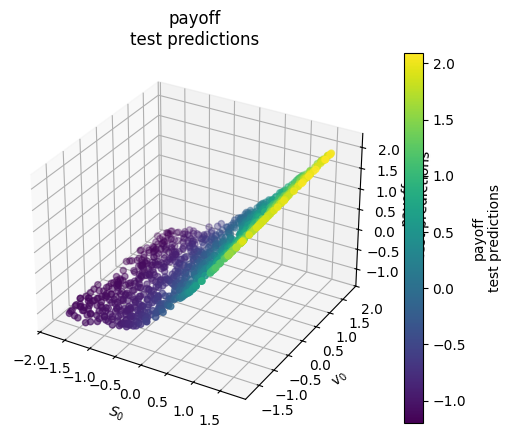

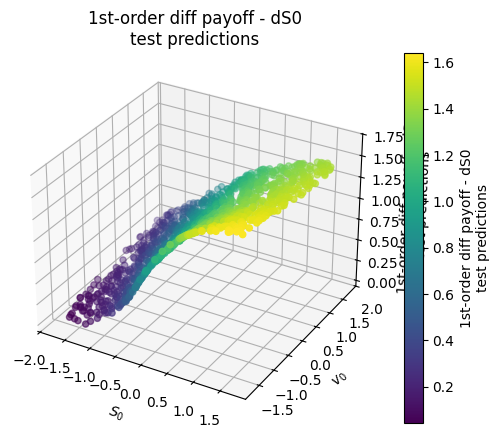

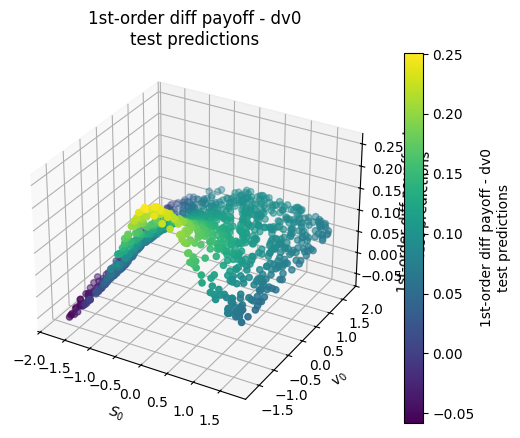

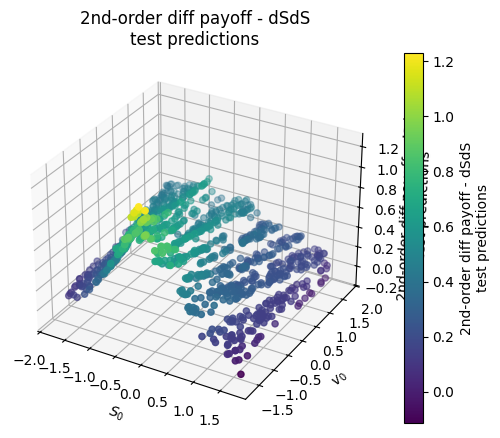

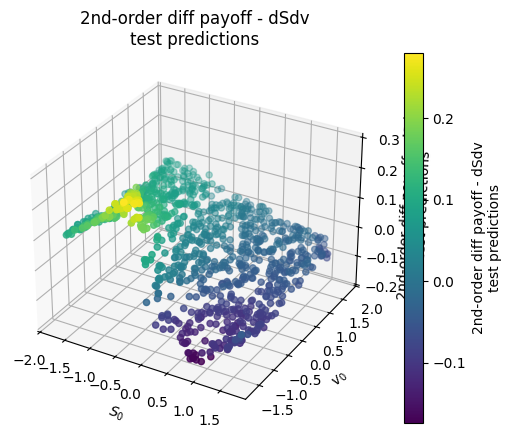

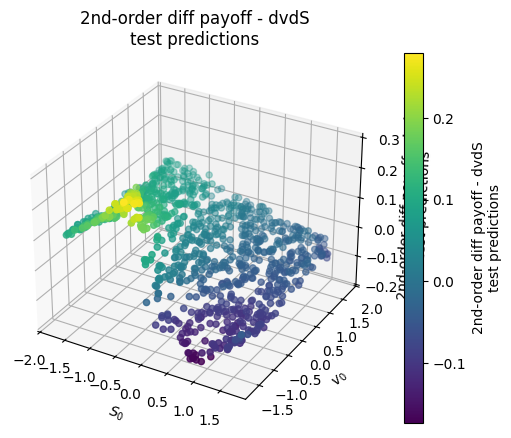

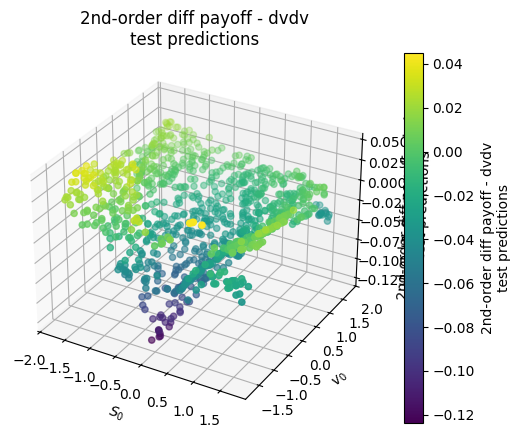

In [91]:
x = test_set[0]
y = test_pred_ys
dydx = test_pred_dys
ddyddx = test_pred_ddys

#ref_model.visualize_dataset(
#    dataset=(
#        x,
#        y, 
#        dydx, 
#        ddyddx,
#        None
#    ), 
#    name="Predictions", 
#    second_order=True
#)


test_size = x.shape[0]
# for visualization slice out diagonal blocks of Hessian
ddyddx = jnp.stack([ddyddx[:,i,: ,i,:] for i in range(ref_model.basket_dim)], axis=1)



x = x.reshape(test_size, ref_model.basket_dim, 2)
dydx = dydx.reshape(test_size, ref_model.basket_dim, 2)
ddyddx = ddyddx.reshape(test_size, ref_model.basket_dim, 2, 2)

# selecting first basket dimension
x = x[:, 0, :]  # (batch_size, 2)
y = y  # (batch_size, )
dydx = dydx[:, 0, :]  # (batch_size, 2)
ddyddx = ddyddx[:, 0, :, :]  # (batch_size, k_probe_directions, 2, 2)

print("shapes after getting rid of the basket dimension:")
print("x shape: ", x.shape)
print("y shape: ", y.shape)
print("dydx shape: ", dydx.shape)
print("ddyddx shape: ", ddyddx.shape)




# plot the predictions
xs = x[..., 0]
ys = x[..., 1]



fig_payoff = plot_3d_differential_data(xs, ys, y, "payoff\ntest predictions")



fig_dS = plot_3d_differential_data(xs, ys, dydx[:, 0], "1st-order diff payoff - dS0\ntest predictions")
fig_dv = plot_3d_differential_data(xs, ys, dydx[:, 1], "1st-order diff payoff - dv0\ntest predictions")



fig_dSdS = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 0], "2nd-order diff payoff - dSdS\ntest predictions")
fig_dSdv = plot_3d_differential_data(xs, ys, ddyddx[:, 0, 1], "2nd-order diff payoff - dSdv\ntest predictions")
fig_dvdS = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 0], "2nd-order diff payoff - dvdS\ntest predictions")
fig_dvdv = plot_3d_differential_data(xs, ys, ddyddx[:, 1, 1], "2nd-order diff payoff - dvdv\ntest predictions")

